# **Market Stock Prediction Using Batch Learning**

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as skl
import plotly

In [30]:
data = pd.read_csv('./data/BTCUSDT.csv', index_col=0)
data.index = pd.to_datetime(data['date'])
data = data.drop(columns=['date'])
data.shape

(1000, 5)

In [31]:
data.head()

open      high       low     close       volume
date                                                           
2022-04-29  39742.06  39925.25  38175.00  38596.11  51453.65715
2022-04-30  38596.11  38795.38  37578.20  37630.80  35321.18989
2022-05-01  37630.80  38675.00  37386.38  38468.35  38812.24104
2022-05-02  38468.35  39167.34  38052.00  38525.16  53200.92628
2022-05-03  38525.16  38651.51  37517.80  37728.95  40316.45358

In [32]:
data.index.max(), data.index.min() 

(Timestamp('2025-01-22 00:00:00'), Timestamp('2022-04-29 00:00:00'))

What we want to predict/forcast is the close price.

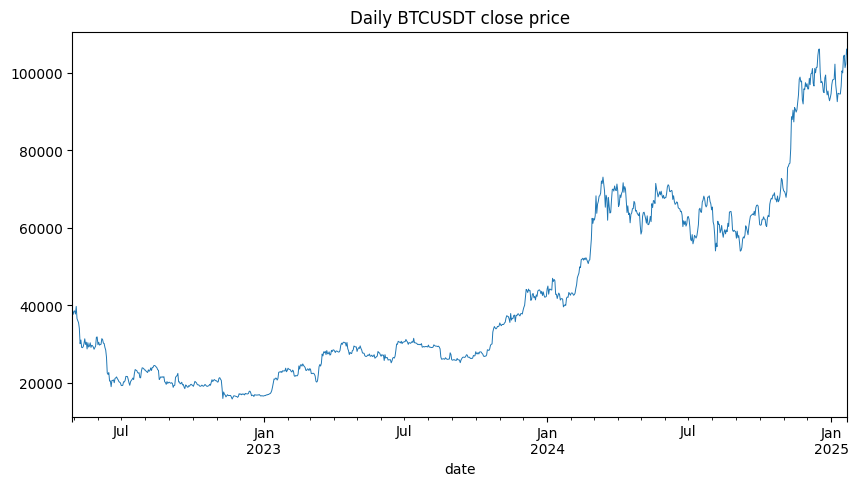

In [33]:
plt.figure(figsize=(10, 5))
data['close'].plot(linewidth=0.7)
plt.title("Daily BTCUSDT close price")
plt.show()


In [6]:
data['close'].describe()


count      1000.000000
mean      42251.597050
std       23294.107111
min       15781.290000
25%       23545.567500
50%       30291.730000
75%       62065.000000
max      106143.820000
Name: close, dtype: float64

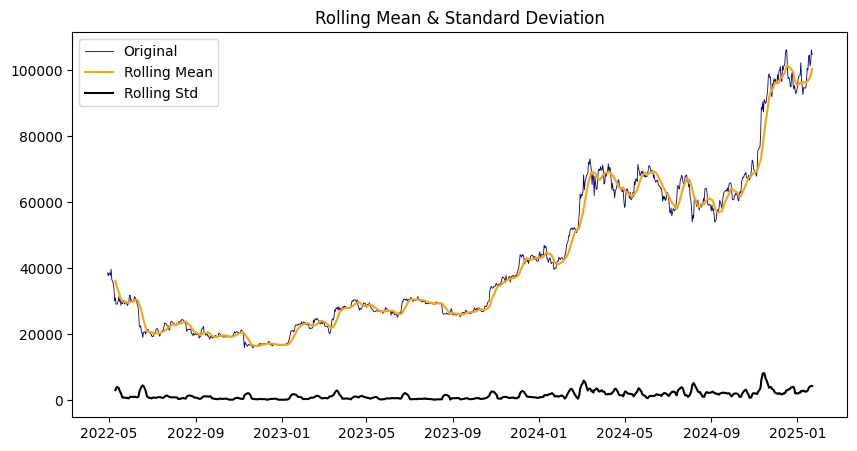

Results of Dickey-Fuller Test:
Test Statistic                   1.334427
p-value                          0.996795
#Lags Used                       6.000000
Number of Observations Used    993.000000
Critical Value (1%)             -3.436953
Critical Value (5%)             -2.864455
Critical Value (10%)            -2.568322
dtype: float64


In [7]:
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()
    # Plot rolling statistics:
    plt.figure(figsize=(10, 5))
    orig = plt.plot(timeseries, color='navy',label='Original', linewidth=0.6)
    mean = plt.plot(rolmean, color='orange', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC') #autolag = 'AIC' is the Akaike Information Criterion
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

test_stationarity(data['close'])


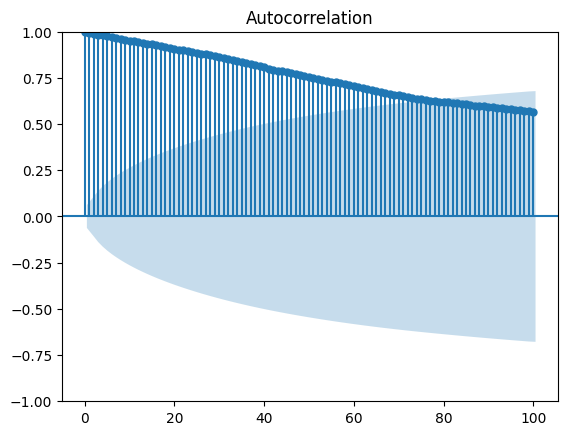

In [8]:
plot_acf(data['close'], lags=100)
plt.show()
plot_pacf(data['close'], lags=50)
plt.show()


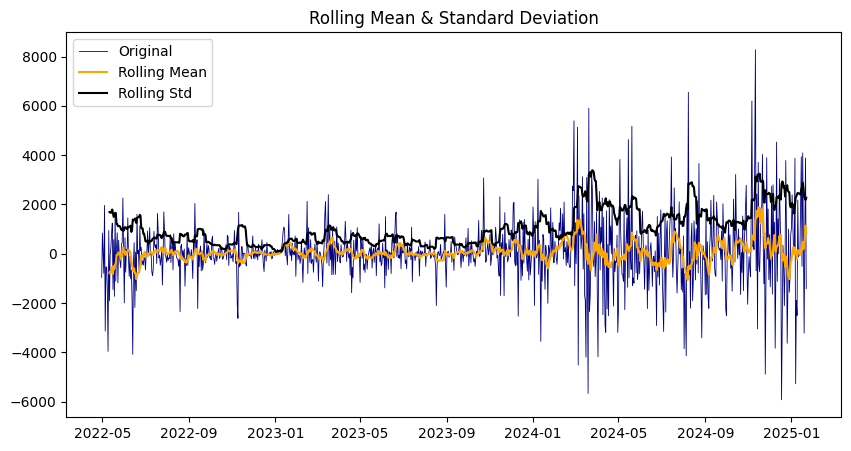

Results of Dickey-Fuller Test:
Test Statistic                -1.357013e+01
p-value                        2.223139e-25
#Lags Used                     5.000000e+00
Number of Observations Used    9.930000e+02
Critical Value (1%)           -3.436953e+00
Critical Value (5%)           -2.864455e+00
Critical Value (10%)          -2.568322e+00
dtype: float64


In [9]:
diff = data['close'].diff().dropna()
test_stationarity(diff)


In [10]:
plot_pacf(diff, lags=20)
plt.show()
plot_acf(diff, lags=20)
plt.show()

So we will adopt a model : p = 1, d = 1, q = 1

In [34]:
y_train, y_test = data['close'][:int(len(data)*0.7)], data['close'][int(len(data)*0.7):]
x_train, x_test = data.drop('close', axis=1)[:int(len(data)*0.7)], data.drop('close', axis=1)[int(len(data)*0.7):]

In [35]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((700, 4), (300, 4), (700,), (300,))

In [13]:
y_train.head()

date
2022-04-29    38596.11
2022-04-30    37630.80
2022-05-01    38468.35
2022-05-02    38525.16
2022-05-03    37728.95
Name: close, dtype: float64

In [14]:
import plotly.graph_objects as go
import numpy as np
# PLOT PREDICTIONS 
def Go_plot_predictions(model_fit, data, y_train, y_test, x_test):
    fig_predictions = go.Figure()

    # Real data
    fig_predictions.add_trace(go.Scatter(
        y=data['close'], 
        mode='lines', 
        line=dict(color='black', width=1.3),
        name='Real'
    ))

    # Predicted data
    fitted_values = model_fit.fittedvalues
    forecast_values = model_fit.forecast(steps=len(y_test), exog=x_test.values)
    predicted = np.concatenate([fitted_values, forecast_values])
    fig_predictions.add_trace(go.Scatter(
        y=predicted,
        mode='lines',
        line=dict(color='orange', width=1.3),
        name='Predicted'
    ))

    # Layout settings
    fig_predictions.update_layout(
        title='ARIMAX Model Forecasting of BTCUSDT Close Price',
        xaxis_title='Time',
        yaxis_title='Value',
        template='plotly_white',
        height=600,
        width=900
    )
    # divide the graph into two parts a left part for training data and a right part for testing data, fill the part with different colors
    fig_predictions.add_shape(
        type="rect",
        x0=0,
        x1=len(y_train),
        y0=0,
        y1=data['close'].max(),
        line=dict(width=0),
        fillcolor="LightSkyBlue",
        opacity=0.1,
        layer="below", 
        name='Training phase'
    )

    fig_predictions.add_shape(
        type="rect",
        x0=len(y_train),
        x1=len(data),
        y0=0,
        y1=data['close'].max(),
        line=dict(width=0),
        fillcolor="LightCoral",
        opacity=0.1,
        layer="below", 
        name='Testing phase'
    )

    fig_predictions.show()
    # PLOT RESIDUALS
    fig_residuals = go.Figure()

    # Residuals data
    fig_residuals.add_trace(go.Scatter(
        y= np.concatenate([model_fit.resid, - forecast_values + y_test]),
        mode='lines',
        line=dict(color='purple', width=0.7),
        name='Residuals'
    ))

    # Layout settings
    fig_residuals.update_layout(
        title='ARIMA Model Residuals',
        xaxis_title='Time',
        yaxis_title='Residuals',
        template='plotly_white',
        height=600,
        width=850
    )

    fig_residuals.show()

In [15]:
# metrics
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

def metrics(y_true, y_pred):
    mse = root_mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return mse, mae, r2, mape

    - Seasonal ARIMA model

In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(y_train.values, order=(1,1,1))#, exog= x_train.values)
model_fit = model.fit()

model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  700
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -5779.810
Date:                Wed, 22 Jan 2025   AIC                          11565.621
Time:                        23:21:17   BIC                          11579.270
Sample:                             0   HQIC                         11570.897
                                - 700                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3058      0.209     -1.460      0.144      -0.716       0.105
ma.L1          0.2166      0.208      1.039      0.299      -0.192       0.625
sigma2      8.946e+05   2.09e+04     42.705      0.000    8.54e+05    9.36e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):              2453.58
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               2.34   Skew:                             0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:

Go_plot_predictions(model_fit, data, y_train, y_test, x_test)

In [19]:
mse, mae, r2, mape = metrics(y_test, model_fit.forecast(steps=len(y_test)))
print("Test metrics FOR SARIMA:")
print(f'RMSE: {mse}\nMAE: {mae}\nR2: {r2}\nMAPE: {mape}')


Test metrics FOR SARIMA:
RMSE: 14890.304475698445
MAE: 11593.608681343516
R2: -0.010047550526864457
MAPE: 0.150160597584917


    - ARIMAX

In [20]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


model = SARIMAX(y_train.values, order=(1,1,1), exog=x_train.values)
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  700
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -5090.981
Date:                Wed, 22 Jan 2025   AIC                          10195.963
Time:                        23:22:39   BIC                          10227.810
Sample:                             0   HQIC                         10208.274
                                - 700                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.5341      0.018    -29.937      0.000      -0.569      -0.499
x2             0.8535      0.018     47.114      0.000       0.818       0.889
x3             0.6783      0.015     45.078      0.000       0.649       0.708
x4            -0.0002      0.000     -1.056      0.291      -0.001       0.000
ar.L1         -0.0616      0.036     -1.701      0.089      -0.133       0.009
ma.L1         -0.9878      0.014    -70.105      0.000      -1.015      -0.960
sigma2      1.726e+05   1.69e-08   1.02e+13      0.000    1.73e+05    1.73e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               666.02
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               1.49   Skew:                            -0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.69e+30. Standard errors may be unstable.
"""

In [21]:
Go_plot_predictions(model_fit, data, y_train, y_test, x_test)

In [22]:

mse, mae, r2, mape = metrics(y_test, model_fit.forecast(steps=len(y_test), exog=x_test.values))
print("Test metrics FOR SARIMAX:")
print(f'RMSE: {mse}\nMAE: {mae}\nR2: {r2}\nMAPE: {mape}')


Test metrics FOR SARIMAX:
RMSE: 752.0457244917677
MAE: 530.2701089487332
R2: 0.9974235414711199
MAPE: 0.0073478389556827185


We conclude that the multiple linear regression model is the best model for this dataset.

In [23]:
# Use prophet model to predict the future price of BTCUSDT
from prophet import Prophet

m = Prophet()

data_prophet = pd.DataFrame(y_train)
data_prophet['ds'] = data_prophet.index
data_prophet.columns = ['y', 'ds']
m.fit(data_prophet)


c:\Users\akilh\OneDrive\Bureau\TELECOM_3A\DataScience-X\DataStreamProcessing\project\StockMarketPrediction\myvenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

23:23:14 - cmdstanpy - INFO - Chain [1] start processing
23:23:14 - cmdstanpy - INFO - Chain [1] done processing


In [24]:
y_test_prophet = pd.DataFrame(y_test)
y_test_prophet['ds'] = y_test_prophet.index
y_test_prophet.columns = ['y', 'ds']

future = m.make_future_dataframe(periods=len(y_test))
future.tail()


ds
995 2025-01-18
996 2025-01-19
997 2025-01-20
998 2025-01-21
999 2025-01-22

In [25]:
forcast = m.predict(future)
forcast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds           yhat     yhat_lower     yhat_upper
995 2025-01-18  127592.831177  107610.132433  149376.317176
996 2025-01-19  127877.445967  107760.273756  149996.402763
997 2025-01-20  128203.594843  107803.595449  150428.904500
998 2025-01-21  128377.383314  108052.950760  149795.870240
999 2025-01-22  128739.466413  108286.009870  151761.674676

In [26]:
from prophet.plot import plot_plotly, plot_components_plotly

fig = plot_plotly(m, forcast, xlabel='Date', ylabel='Close Price')
fig.show()


In [27]:
# plot using plotly the close price and the forecasted price
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=data.index, 
    y=data['close'], 
    mode='lines', 
    line=dict(color='brown', width=1.3),
    name='Real'
))

fig.add_trace(go.Scatter(
    x=forcast['ds'], 
    y=forcast['yhat'], 
    mode='lines', 
    line=dict(color='orange', width=1.3),
    name='Predicted'
))

fig.update_layout(
    title='Prophet Model Forecasting of BTCUSDT Close Price',
    xaxis_title='Time',
    yaxis_title='Value',
    template='plotly_white',
    height=600,
    width=900
)

fig.show()

---

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as skl
import plotly
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
import xgboost as xgb

In [37]:
x_trainc = x_train.copy()
x_testc = x_test.copy()
# Création de lag features
x_trainc['lag_close_1'] = y_train.shift(1)  # Close à t-1
x_trainc['lag_close_2'] = y_train.shift(2)  # Close à t-2

# Moyennes mobiles
x_trainc['rolling_mean_3'] = y_train.rolling(window=3).mean()  # Moyenne sur 3 périodes
x_trainc['rolling_std_3'] = y_train.rolling(window=3).std()    # Écart-type sur 3 périodes


x_trainc['lag_close_1'].fillna(x_trainc['lag_close_1'].mean(), inplace=True)
x_trainc['lag_close_2'].fillna(x_trainc['lag_close_2'].mean(), inplace=True)
x_trainc['rolling_mean_3'].fillna(x_trainc['rolling_mean_3'].mean(), inplace=True)
x_trainc['rolling_std_3'].fillna(x_trainc['rolling_std_3'].mean(), inplace=True)


C:\Users\akilh\AppData\Local\Temp\ipykernel_4372\3821732317.py:12: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



C:\Users\akilh\AppData\Local\Temp\ipykernel_4372\3821732317.py:13: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=

In [41]:
# Création de lag features
x_testc['lag_close_1'] = y_test.shift(1)  # Close à t-1
x_testc['lag_close_2'] = y_test.shift(2)  # Close à t-2

# Moyennes mobiles
x_testc['rolling_mean_3'] = y_test.rolling(window=3).mean()  # Moyenne sur 3 périodes
x_testc['rolling_std_3'] = y_test.rolling(window=3).std()    # Écart-type sur 3 périodes
x_testc['lag_close_1'].fillna(x_testc['lag_close_1'].mean(), inplace=True)
x_testc['lag_close_2'].fillna(x_testc['lag_close_2'].mean(), inplace=True)
x_testc['rolling_mean_3'].fillna(x_testc['rolling_mean_3'].mean(), inplace=True)
x_testc['rolling_std_3'].fillna(x_testc['rolling_std_3'].mean(), inplace=True)

C:\Users\akilh\AppData\Local\Temp\ipykernel_4372\2141128003.py:8: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



C:\Users\akilh\AppData\Local\Temp\ipykernel_4372\2141128003.py:9: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

In [42]:
rf = RandomForestRegressor(n_estimators=200, min_samples_split= 5, min_samples_leaf= 1, max_depth= 10,random_state=42)
rf.fit(x_trainc, y_train)
y_pred_rf = rf.predict(x_testc)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"Random Forest MSE: {mse_rf}")

Random Forest MSE: 163824798.3317963


In [43]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
random_search = RandomizedSearchCV(RandomForestRegressor(random_state=42), param_distributions=param_dist, n_iter=50, cv=5, scoring='neg_mean_squared_error', random_state=42)
random_search.fit(x_trainc, y_train)
print(f"Meilleurs paramètres : {random_search.best_params_}")
rf = random_search.best_estimator_


Meilleurs paramètres : {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}


In [44]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_trainc)
x_test_scaled = scaler.transform(x_testc)

svr = SVR(kernel='rbf', C=100000, gamma=0.001)
svr.fit(x_train_scaled, y_train)
y_pred_svr = svr.predict(x_test_scaled )

# Évaluation du modèle
mse_svr = mean_squared_error(y_test, y_pred_svr)
print(f"SVR MSE: {mse_svr}")

SVR MSE: 11132443.787956452


In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

param_grid = {
    'C': [100, 1000, 10000, 100000],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['rbf']
}
grid_search = GridSearchCV(SVR(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(x_train_scaled, y_train)
print(f"Meilleurs paramètres : {grid_search.best_params_}")
svr = grid_search.best_estimator_

Meilleurs paramètres : {'C': 100000, 'gamma': 0.001, 'kernel': 'rbf'}


In [47]:
# Définition de la grille des hyperparamètres
param_dist = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 10, None],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'min_child_weight': [1, 3, 5]
}

# Instanciation de XGBoost Regressor
xgbr = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Créer un modèle XGBoost de base
xgbr = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0,
    min_child_weight=1
)

# Entraîner le modèle
xgbr.fit(x_trainc, y_train)

# Définir le meilleur estimateur comme étant le modèle entraîné
xgbr_best = xgbr

# Ajustement du modèle
random_search.fit(x_trainc, y_train)

# Meilleurs hyperparamètres
print(f"Meilleurs paramètres : {random_search.best_params_}")

# Utilisation du meilleur modèle
xgbr_best = random_search.best_estimator_

# Entraînement du meilleur modèle
xgbr_best.fit(x_trainc, y_train)

# Prédictions
y_pred_xgb = xgbr_best.predict(x_testc)

# Évaluation du modèle
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
print(f"XGBoost MSE: {mse_xgb}")

c:\Users\akilh\OneDrive\Bureau\TELECOM_3A\DataScience-X\DataStreamProcessing\project\StockMarketPrediction\myvenv\lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning:

The XGBRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.



AttributeError: 'super' object has no attribute '__sklearn_tags__'

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Valeur réelle', color='blue')
plt.plot(y_test.index, y_pred_rf, label='Random Forest', color='green')
plt.plot(y_test.index, y_pred_xgb, label='XGBoost', color='orange')
plt.plot(y_test.index, y_pred_svr, label='SVR', color='red')
plt.legend()
plt.title("Comparaison des modèles pour la prédiction de Close")
plt.xlabel("Date")
plt.ylabel("Valeur Close")
plt.show()